In [2]:
import torch
import matplotlib.pyplot as plt 
import torchvision
import numpy as np


In [3]:
import sys
import os

sys.path.append(os.path.abspath("../../"))
from src.utils.data_fetcher import create_loaders

import yaml

with open("../../config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

# Get the path from config
data_root = cfg["paths"]['output_root']

# FIX for Jupyter/notebook: Use current working directory instead of __file__
current_working_dir = os.getcwd()  # This works in notebooks
data_root = os.path.join(current_working_dir, data_root)

print(f"✅ Current working directory: {current_working_dir}")
print(f"✅ Data root path: {data_root}")
print(f"✅ Path exists: {os.path.exists(data_root)}")


✅ Current working directory: /home/yasser/classes/DL26/final_Project/notebooks/yasser
✅ Data root path: /home/yasser/classes/DL26/final_Project/notebooks/yasser/data/preprocessed
✅ Path exists: False


In [10]:
train_loader, val_loader, test_loader = create_loaders(
    root="../../data/preprocessed",
    batch_size=128,
    num_workers=3,
    use_augmentation=False)


📦 DATA LOADED:
  Train: 64800 samples
  Val:   8100 samples
  Test:  8100 samples


In [34]:
lr, hr = next(iter(train_loader))
print(lr.shape,hr.shape)

torch.Size([48, 3, 48, 48]) torch.Size([48, 3, 192, 192])


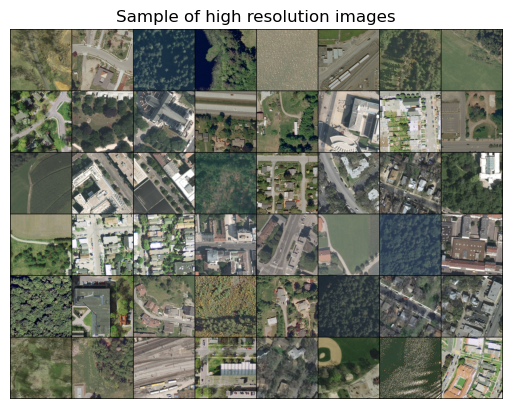

In [35]:
# create grid (use existing `cols` if available)
cols=8
grid = torchvision.utils.make_grid(hr, nrow=cols)

# convert to numpy (move to CPU if necessary) and reshape for matplotlib
npimg = grid.cpu().numpy()
npimg = np.transpose(npimg, (1, 2, 0))  # C,H,W -> H,W,C
npimg = npimg.squeeze()  
plt.title("Sample of high resolution images")
plt.imshow(npimg, cmap='gray')
plt.axis('off')
plt.show()

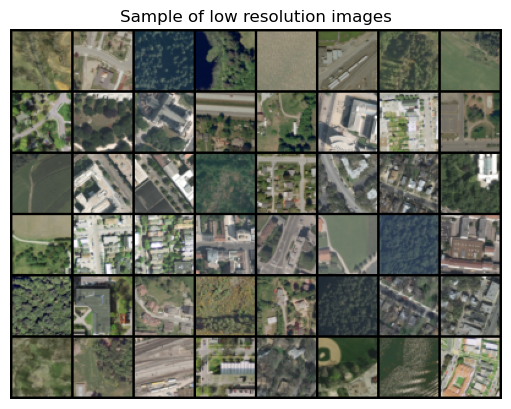

In [36]:
# create grid (use existing `cols` if available)
cols=8
grid = torchvision.utils.make_grid(lr, nrow=cols)

# convert to numpy (move to CPU if necessary) and reshape for matplotlib
npimg = grid.cpu().numpy()
npimg = np.transpose(npimg, (1, 2, 0))  # C,H,W -> H,W,C
npimg = npimg.squeeze()  
plt.title("Sample of low resolution images")
plt.imshow(npimg, cmap='gray')
plt.axis('off')
plt.show()

In [43]:
# Let's debug with a simple check
def debug_single_image():
    lr, hr = train_dataset[0]
    print(f"Single image check:")
    print(f"  LR shape: {lr.shape}")
    print(f"  LR min/max: {lr.min():.4f}, {lr.max():.4f}")
    print(f"  LR mean per channel: {lr.mean(dim=(1,2))}")
    print(f"  HR min/max: {hr.min():.4f}, {hr.max():.4f}")
    print(f"  HR mean per channel: {hr.mean(dim=(1,2))}")

🔍 INSPECTING DATASET:

📸 Image 0:
  LR - Shape: torch.Size([3, 48, 48])
      Range: [0.1137, 0.6902]
      Mean per channel: [0.2933312654495239, 0.29368531703948975, 0.286391943693161]
  HR - Shape: torch.Size([3, 192, 192])
      Range: [0.0902, 0.8706]
      Mean per channel: [0.2940859794616699, 0.29441988468170166, 0.28682175278663635]


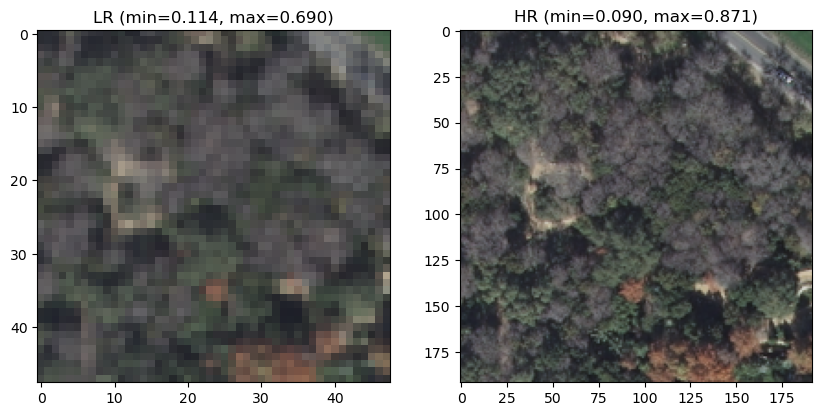


📸 Image 1:
  LR - Shape: torch.Size([3, 48, 48])
      Range: [0.1176, 0.7333]
      Mean per channel: [0.4269999563694, 0.4239294230937958, 0.3956240117549896]
  HR - Shape: torch.Size([3, 192, 192])
      Range: [0.0902, 0.9176]
      Mean per channel: [0.4291159510612488, 0.4261151850223541, 0.3972841501235962]


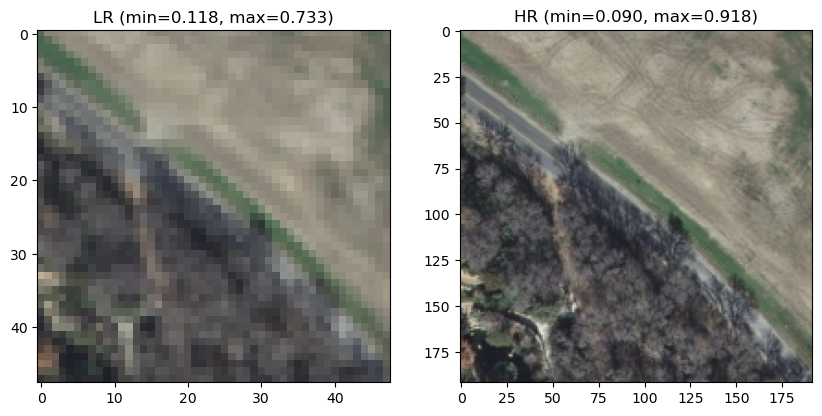

In [44]:
import matplotlib.pyplot as plt

def inspect_dataset(dataset, n=3):
    print("🔍 INSPECTING DATASET:")
    for i in range(min(n, len(dataset))):
        lr, hr = dataset[i]
        
        print(f"\n📸 Image {i}:")
        print(f"  LR - Shape: {lr.shape}")
        print(f"      Range: [{lr.min():.4f}, {lr.max():.4f}]")
        print(f"      Mean per channel: {lr.mean(dim=(1,2)).tolist()}")
        print(f"  HR - Shape: {hr.shape}")
        print(f"      Range: [{hr.min():.4f}, {hr.max():.4f}]")
        print(f"      Mean per channel: {hr.mean(dim=(1,2)).tolist()}")
        
        # Visualize
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(lr.permute(1, 2, 0))
        axes[0].set_title(f"LR (min={lr.min():.3f}, max={lr.max():.3f})")
        axes[1].imshow(hr.permute(1, 2, 0))
        axes[1].set_title(f"HR (min={hr.min():.3f}, max={hr.max():.3f})")
        plt.show()

inspect_dataset(train_dataset, n=2)

In [11]:
import torch
from torch.utils.data import DataLoader

def compute_mean_std_cuda(loader, device="cuda"):
    lr_sum = torch.zeros(3, device=device)
    lr_sq_sum = torch.zeros(3, device=device)
    hr_sum = torch.zeros(3, device=device)
    hr_sq_sum = torch.zeros(3, device=device)

    total_lr_pixels = 0
    total_hr_pixels = 0

    for i, (lr, hr) in enumerate(loader):
        
        lr = lr.to(device)
        hr = hr.to(device)

        b, c, h_lr, w_lr = lr.shape
        _, _, h_hr, w_hr = hr.shape   # get HR shape separately

        # Pixel counters
        total_lr_pixels += b * h_lr * w_lr
        total_hr_pixels += b * h_hr * w_hr

        # LR accumulations
        lr_sum += lr.sum(dim=[0,2,3])
        lr_sq_sum += (lr * lr).sum(dim=[0,2,3])

        # HR accumulations
        hr_sum += hr.sum(dim=[0,2,3])
        hr_sq_sum += (hr * hr).sum(dim=[0,2,3])

        if i % 20 == 0:
            print(f"Processed batch {i}")

    # Final means
    mean_lr = lr_sum / total_lr_pixels
    mean_hr = hr_sum / total_hr_pixels

    # Final stds
    std_lr = torch.sqrt(lr_sq_sum / total_lr_pixels - mean_lr**2)
    std_hr = torch.sqrt(hr_sq_sum / total_hr_pixels - mean_hr**2)

    return (mean_lr.cpu(), std_lr.cpu()), (mean_hr.cpu(), std_hr.cpu())




device = "cuda" if torch.cuda.is_available() else "cpu"

(mean_lr, std_lr), (mean_hr, std_hr) = compute_mean_std_cuda(train_loader, device)

print("\n📊 Dataset Statistics (LR and HR):")
print(f"LR Mean: {mean_lr}")
print(f"LR Std : {std_lr}")
print(f"HR Mean: {mean_hr}")
print(f"HR Std : {std_hr}")



Processed batch 0
Processed batch 20
Processed batch 40
Processed batch 60
Processed batch 80
Processed batch 100
Processed batch 120
Processed batch 140
Processed batch 160
Processed batch 180
Processed batch 200
Processed batch 220
Processed batch 240
Processed batch 260
Processed batch 280
Processed batch 300
Processed batch 320
Processed batch 340
Processed batch 360
Processed batch 380
Processed batch 400
Processed batch 420
Processed batch 440
Processed batch 460
Processed batch 480
Processed batch 500

📊 Dataset Statistics (LR and HR):
LR Mean: tensor([0.4295, 0.4501, 0.4018])
LR Std : tensor([0.1855, 0.1659, 0.1635])
HR Mean: tensor([0.4295, 0.4501, 0.4018])
HR Std : tensor([0.2006, 0.1817, 0.1767])


In [6]:
from PIL import Image
import numpy as np
import os

path = "../../data/preprocessed/train/HR"
sample = sorted(os.listdir(path))[0]
img = Image.open(os.path.join(path, sample))

print("Mode:", img.mode)
print("Extrema:", img.getextrema())   # min/max per channel
print("Numpy dtype:", np.array(img).dtype)


Mode: RGB
Extrema: ((24, 217), (23, 222), (23, 212))
Numpy dtype: uint8
